In [1]:
import numpy as np
import pandas as pd
import cv2, imageio
import os

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, \
Conv2D, Flatten, TimeDistributed, LSTM

import warnings
warnings.filterwarnings('ignore')

In [2]:
def build_imagenet_model(pretrained_model):

    base_model_out = pretrained_model.output

    base_model_out = Flatten()(base_model_out)

    # Add 3 dense layers so that the model can learn aspects of our new dataset
    base_model_out = Dense(1024, activation='relu')(base_model_out)
    base_model_out = Dropout(0.5)(base_model_out)
    base_model_out = BatchNormalization()(base_model_out)
    
    base_model_out = Dense(512, activation='relu')(base_model_out)
    base_model_out = Dropout(0.25)(base_model_out)
    base_model_out = BatchNormalization()(base_model_out)

    # Add a final layer with 3 neurons, one for each class in our dataset 
    # using a softmabase_model_out activation function:
    preds = Dense(1, activation='sigmoid')(base_model_out)

    # Instantiate our final model, where we specify what are the inputs and 
    # the outputs will look like
    model = Model(inputs = pretrained_model.input, outputs = preds)
    
    return model

In [6]:
# modified from https://mc.ai/train-keras-model-with-large-dataset-batch-training/
def load_data(df, batch_n, batch_size, subset):
    if batch_n > 0:
        df = pd.read_csv(df, skiprows=batch_n*batch_size+1, nrows=batch_size, names=['filename', 'label'])
    else:
        df = pd.read_csv(df, skiprows=batch_n*batch_size, nrows=batch_size)
    
    frames = []
    for dir in df['filename']:
        try:
            frame_path = subset + '/' + dir + '/' + os.listdir(subset + '/' + dir)[14]
        #if 15th frame does not exist, use first frame
        except IndexError:
            frame_path = subset + '/' + dir + '/' + os.listdir(subset + '/' + dir)[0]

        frame = imageio.imread(frame_path)

        frames.append(frame)
    
    frames = np.array(frames)
    x = frames.astype('float32')
    x /= 255
    
    y = np.array(df['label'])
    
    #print(f'{batch_n} passed')
    return (x, y)

def batch_generator(df, batch_size, steps, subset):
    batch_n=1
    while True: 
        yield load_data(df, batch_n-1, batch_size, subset)
    if batch_n < steps:
        batch_n+=1
    else:
        batch_n=1

## Baseline CNN Performance using 1 frame per video

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

In [28]:
model = build_imagenet_model(vgg)

In [29]:
for layer in model.layers[:len(vgg.layers)]:
    layer.trainable = False
    
opt = Adam(lr=0.001, decay = 0.0001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [30]:
EPOCHS = 10
BATCH_SIZE = 8
TOTAL_FILES = metadata_train.shape[0]

steps_per_epoch = np.ceil(TOTAL_FILES/BATCH_SIZE)
train_generator = batch_generator('train.csv', BATCH_SIZE, steps_per_epoch, subset='train')
validation_generator = batch_generator('validation.csv', BATCH_SIZE, steps_per_epoch, subset='validation')

In [34]:
model.fit_generator(train_generator, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, \
                    verbose=1, shuffle=True, validation_data=validation_generator, validation_steps=steps_per_epoch)

Epoch 1/10
699/699 [==============================] - 138s 197ms/step - loss: 0.0943 - acc: 0.9624 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 2/10
699/699 [==============================] - 134s 191ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 8.2778e-04 - val_acc: 1.0000
Epoch 3/10
699/699 [==============================] - 134s 191ms/step - loss: 5.2082e-04 - acc: 1.0000 - val_loss: 2.8932e-04 - val_acc: 1.0000
Epoch 4/10
211/699 [========>.....................] - ETA: 52s - loss: 3.0572e-04 - acc: 1.0000

KeyboardInterrupt: 

In [33]:
metadata_train.shape[0]

5585

In [32]:
metadata_train = pd.read_csv('metadata_train.csv')
metadata_train['filename'] = metadata_train['filename'].str.replace('data_30/', '')

# export csv with clean filenames for batch generation
metadata_train.to_csv('train.csv', index=False)

In [24]:
metadata_validation = pd.read_csv('metadata_validation.csv')
metadata_validation['filename'] = metadata_validation['filename'].str.replace('train/', '')

metadata_validation.to_csv('validation.csv', index=False)

In [77]:
test_files = metadata_train.sample(n=192, random_state=1)
test_files.to_csv('test_file.csv', index=False)

In [7]:
val_files = metadata_validation.sample(n=128, random_state=1)
val_files.to_csv('validation_file.csv', index=False)

In [16]:
pd.read_csv('validation_file.csv')

,filename,label
0,yidrboessk,1
1,ammowfdpae,1
2,cytdctacrw,1
3,huhzyknoqo,1
4,yfzulfwjue,1
...,...,...
123,geglgdrsgp,1
124,hsvbimzuza,1
125,yxdleubquk,1
126,xhwnzeozrd,1


In [30]:
EPOCHS = 10
BATCH_SIZE = 8
TOTAL_FILES = 64

steps_per_epoch = np.ceil(TOTAL_FILES/BATCH_SIZE)
my_batch_generator = batch_generator('test_file.csv', BATCH_SIZE, steps_per_epoch)

In [10]:
val_batch_generator = batch_generator('val_file.csv', BATCH_SIZE, steps_per_epoch)

In [9]:
my_model.fit_generator(my_batch_generator, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, verbose=1, shuffle=True)

Epoch 1/10
8/8 [==============================] - 3s 430ms/step - loss: 0.7035 - acc: 0.6875
Epoch 2/10
8/8 [==============================] - 1s 86ms/step - loss: 0.6903 - acc: 0.7500: 0s - loss: 0.6909 - acc: 0
Epoch 3/10
8/8 [==============================] - 1s 85ms/step - loss: 0.6884 - acc: 0.7500
Epoch 4/10
8/8 [==============================] - 1s 86ms/step - loss: 0.6865 - acc: 0.7500
Epoch 5/10
8/8 [==============================] - 1s 85ms/step - loss: 0.6846 - acc: 0.7500
Epoch 6/10
8/8 [==============================] - 1s 85ms/step - loss: 0.6827 - acc: 0.7500
Epoch 7/10
8/8 [==============================] - 1s 86ms/step - loss: 0.6808 - acc: 0.7500
Epoch 8/10
8/8 [==============================] - 1s 85ms/step - loss: 0.6790 - acc: 0.7500
Epoch 9/10
8/8 [==============================] - 1s 85ms/step - loss: 0.6772 - acc: 0.7500
Epoch 10/10
8/8 [==============================] - 1s 87ms/step - loss: 0.6753 - acc: 0.7500


In [11]:
prediction = my_model.predict_generator(val_batch_generator, steps=1)

In [12]:
prediction

array([[0.5158261],
       [0.5195586],
       [0.5195586],
       [0.5195586],
       [0.5195586],
       [0.5195586],
       [0.5195586],
       [0.5195586]], dtype=float32)

In [122]:
val_pred = prediction.argmax(axis=1)

In [125]:
val_pred

array([1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [23]:
base_model_out = vgg.output

base_model_out = Flatten()(base_model_out)

# Add 3 dense layers so that the model can learn aspects of our new dataset 
# and classify for better results.
base_model_out = Dense(4, activation='relu')(base_model_out)

# Add a final layer with 3 neurons, one for each class in our dataset 
# using a softmabase_model_out activation function:
preds = Dense(2, activation='softmax')(base_model_out)

# Instantiate our final model, where we specify what are the inputs and 
# the outputs will look like
model = Model(inputs = vgg.input, outputs = preds)

In [24]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16019374111304201060
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1431348428
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4326638991357481936
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [26]:
model.fit_generator(my_batch_generator, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, verbose=1) #shuffle=True

Epoch 1/2
0 passed
0 passed
0 passed
0 passed
0 passed
0 passed
0 passed
0 passed
0 passed
0 passed
0 passed
3/3 [==============================] - 50s 17s/step - loss: 0.9921 - acc: 0.8500
Epoch 2/2
0 passed
3/3 [==============================] - 43s 14s/step - loss: 0.4562 - acc: 0.8500


In [101]:
X = frames
y = np.array([1, 1, 0, 0, 1])

model.fit(X, y, epochs=10, verbose=2)

Epoch 1/10
 - 1s - loss: 0.6924 - acc: 0.6000
Epoch 2/10
 - 1s - loss: 0.6923 - acc: 0.6000
Epoch 3/10
 - 1s - loss: 0.6921 - acc: 0.6000
Epoch 4/10
 - 1s - loss: 0.6920 - acc: 0.6000
Epoch 5/10
 - 1s - loss: 0.6918 - acc: 0.6000
Epoch 6/10
 - 1s - loss: 0.6916 - acc: 0.6000
Epoch 7/10
 - 1s - loss: 0.6915 - acc: 0.6000
Epoch 8/10
 - 1s - loss: 0.6913 - acc: 0.6000
Epoch 9/10
 - 1s - loss: 0.6912 - acc: 0.6000
Epoch 10/10
 - 1s - loss: 0.6910 - acc: 0.6000


In [107]:
names = []
for dir in os.listdir('test_dir'):
    names.append(dir)

test_metadata = pd.DataFrame({'names':names, 'labels':[1,1,0,0,1]})

test_metadata.to_csv('test_metadata.csv', index=False)

In [137]:
a, b = load_data('test_metadata.csv', 0, 2)

In [140]:
batch_size = 2

steps_per_epoch=np.ceil(5/batch_size)
my_training_batch_generator = batch_generator('test_metadata.csv', batch_size, steps_per_epoch)

In [144]:
model.fit_generator(my_training_batch_generator, epochs=10, steps_per_epoch=steps_per_epoch,
                    shuffle=True, verbose=1) # use_multiprocessing=True

Epoch 1/10
3/3 [==============================] - 1s 434ms/step - loss: 0.6476 - acc: 1.0000
Epoch 2/10
3/3 [==============================] - 1s 421ms/step - loss: 0.6443 - acc: 1.0000
Epoch 3/10
3/3 [==============================] - 1s 442ms/step - loss: 0.6411 - acc: 1.0000
Epoch 4/10
3/3 [==============================] - 1s 467ms/step - loss: 0.6379 - acc: 1.0000
Epoch 5/10
3/3 [==============================] - 1s 455ms/step - loss: 0.6348 - acc: 1.0000
Epoch 6/10
3/3 [==============================] - 1s 420ms/step - loss: 0.6317 - acc: 1.0000
Epoch 7/10
3/3 [==============================] - 1s 419ms/step - loss: 0.6286 - acc: 1.0000
Epoch 8/10
3/3 [==============================] - 1s 418ms/step - loss: 0.6255 - acc: 1.0000
Epoch 9/10
3/3 [==============================] - 1s 419ms/step - loss: 0.6225 - acc: 1.0000
Epoch 10/10
3/3 [==============================] - 1s 418ms/step - loss: 0.6195 - acc: 1.0000


In [143]:
model.predict(X, y)

TypeError: only size-1 arrays can be converted to Python scalars

In [102]:
datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

training_set = datagen.flow_from_directory('test_dir', target_size = (160, 160), shuffle=True,
                                             seed=2020, batch_size = 2, class_mode = 'binary',
                                             subset="training")

val_set = datagen.flow_from_directory('test_dir', target_size = (160, 160), shuffle=True,
                                             seed=2020, batch_size = 2, class_mode = 'binary',
                                             subset="validation")

Found 114 images belonging to 5 classes.
Found 26 images belonging to 5 classes.


In [ ]:
# 3D convolution will merge frames together, which may not be desirable.
# https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00

In [18]:
from keras.applications.resnet50 import ResNet50

resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

for layer in resnet.layers[:-4]:
    layer.trainable = False

94658560/94653016 [==============================] - 9s 0us/step


In [16]:
num_classes = 2

model = Sequential()

model.add(
    TimeDistributed(vgg)()
)

model.add(
    TimeDistributed(
        Flatten()
    )
)

model.add(LSTM(256, activation='relu', return_sequences=False))

model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(num_classes, activation='softmax'))

AttributeError: 'tuple' object has no attribute 'as_list'

In [8]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [15]:
model._layers

In [ ]:
X_train = a
y_train = np.array([0, 1])

In [15]:
model.fit(X_train, y_train, epochs = 2, verbose = 1)

Epoch 1/2
2/2 [==============================] - 14s 7s/step - loss: 0.6726 - acc: 1.0000
Epoch 2/2
2/2 [==============================] - 9s 5s/step - loss: 1.1921e-07 - acc: 1.0000


In [70]:
sample_frame = imageio.imread("data_30/aakkdgsmvl/000.png")
sample_frame2 = imageio.imread("data_30/aassnaulhq/000.png")

In [35]:
a = np.array([sample_frame, sample_frame2])

img_rows, img_cols = 160, 160

# scale pixel values to be between 0 and 1
a_scaled = a.astype('float32')
a_scaled /= 255

(2, 160, 160, 3)
(2, 160, 160, 3)


In [44]:
y_train.shape

(2,)

In [24]:
a = np.zeros(shape=(160,160,3))
a.shape

(160, 160, 3)

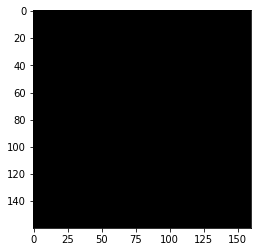

In [25]:
plt.imshow(a);
plt.show()

In [16]:
from tensorflow.keras.applications import Xception

In [17]:
model = Xception(weights='imagenet')

91889664/91884032 [==============================] - 9s 0us/step


In [18]:
model.layers

In [19]:
model.layers[-1].output

<tf.Tensor 'predictions/Softmax:0' shape=(?, 1000) dtype=float32>